In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout
from keras import initializers
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
import gc

Using TensorFlow backend.


In [2]:
# function for clearning train data!
# + remove IP
def clear_data(df, option):
    
    df['click_time'] = pd.to_datetime(df['click_time'])
    df['weekday'] = df['click_time'].dt.dayofweek
    df['hour'] = df['click_time'].dt.hour
    df = df.drop(columns=['ip','click_time'])
    if (option == 'train'):
        y = df['is_attributed']
        df = df.drop(columns=['is_attributed','attributed_time'], axis=1)
        return df, y
    elif (option == 'test'):
        sub_id = df['click_id']
        df = df.drop(columns=['click_id'], axis=1)
        return df, sub_id
    
    

In [3]:
print('load 10% training sample + train/val')
df = pd.read_csv('input_data/train_sampling5.csv')
df, y = clear_data(df,'train')
x_train, x_val, y_train, y_val = train_test_split(df,y,test_size=0.1)

x_train= x_train.drop(columns=['Unnamed: 0'])
x_val= x_val.drop(columns=['Unnamed: 0'])

print(x_train.head(2))
print(x_val.head(2))
print(y_train.head(2))
print(y_val.head(2))
del df, y; gc.collect()

load 10% training sample + train/val
         app  device  os  channel  weekday  hour
2037519   12       1  22      205        1     9
508032    23       1   6      153        3    11
         app  device  os  channel  weekday  hour
7141719    7       1  19      101        1     2
3582802   29       2  37      213        1     1
2037519    0
508032     0
Name: is_attributed, dtype: int64
7141719    0
3582802    1
Name: is_attributed, dtype: int64


89

In [4]:
print("define NN")
model = Sequential()
# give options of Dense, 
# https://github.com/keras-team/keras/blob/befbdaa076eedb2787ce340b1a5b4accf93d123d/examples/mnist_irnn.py
# RNN?? next try!
kernel_init=initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None) #stddev=0.05

# structure of NN: 16 - (32) - 64 - 32 - 16 - (8) - sigmoid
model.add(Dense(16,activation='relu',kernel_initializer=kernel_init,
                bias_initializer='zeros',input_shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(32,kernel_initializer=kernel_init,
                bias_initializer='zeros',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,kernel_initializer=kernel_init,
                bias_initializer='zeros',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32,kernel_initializer=kernel_init,
                bias_initializer='zeros',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(16,kernel_initializer=kernel_init,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


model.add(Dense(8,kernel_initializer=kernel_init,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(1,activation='sigmoid'))


define NN


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                112       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
__________

In [6]:
gc.collect()
print("start training")
# control NN's option
# batch_size = 256
# epoch = 10
batch_size = 10240
epoch = 150  #10

# class_weight = {0:0.1, 1:0.9}
class_weight = {0:0.5, 1:0.5}
# class_weight = {0:0.95, 1:0.05}

exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(list(x_train)[0]) / batch_size) * epoch
lr_init, lr_fin = 0.0012, 0.0008 # lr=0.001 default 
lr_decay = exp_decay(lr_init, lr_fin, steps)
optimizer_adam = optimizers.Adam(lr=0.002, decay=lr_decay)

######################
# compile + training
model.compile(loss='binary_crossentropy',optimizer=optimizer_adam,metrics=['accuracy'])
model.fit(x_train,y_train,batch_size = batch_size,epochs=epoch,validation_data=(x_val,y_val),class_weight=class_weight)

del x_train, y_train; gc.collect()

start training
Train on 7758144 samples, validate on 862016 samples
Epoch 1/150
7758144/7758144 [==============================] - 110s 14us/step - loss: 0.1506 - acc: 0.8931 - val_loss: 0.2604 - val_acc: 0.9184
Epoch 2/150
7758144/7758144 [==============================] - 108s 14us/step - loss: 0.1078 - acc: 0.9203 - val_loss: 0.2017 - val_acc: 0.9287
Epoch 3/150
7758144/7758144 [==============================] - 106s 14us/step - loss: 0.1021 - acc: 0.9284 - val_loss: 0.2060 - val_acc: 0.9351
Epoch 4/150
7758144/7758144 [==============================] - 112s 14us/step - loss: 0.0991 - acc: 0.9320 - val_loss: 0.2070 - val_acc: 0.9336
Epoch 5/150
7758144/7758144 [==============================] - 104s 13us/step - loss: 0.0976 - acc: 0.9334 - val_loss: 0.2187 - val_acc: 0.9350
Epoch 6/150
7758144/7758144 [==============================] - 112s 14us/step - loss: 0.0964 - acc: 0.9345 - val_loss: 0.2213 - val_acc: 0.9404
Epoch 7/150
7758144/7758144 [==============================] - 106s 

7758144/7758144 [==============================] - 100s 13us/step - loss: 0.0900 - acc: 0.9419 - val_loss: 0.1992 - val_acc: 0.9372
Epoch 58/150
7758144/7758144 [==============================] - 101s 13us/step - loss: 0.0899 - acc: 0.9421 - val_loss: 0.2035 - val_acc: 0.9355
Epoch 59/150
7758144/7758144 [==============================] - 102s 13us/step - loss: 0.0899 - acc: 0.9421 - val_loss: 0.2090 - val_acc: 0.9388
Epoch 60/150
7758144/7758144 [==============================] - 105s 14us/step - loss: 0.0897 - acc: 0.9422 - val_loss: 0.1991 - val_acc: 0.9358
Epoch 61/150
7758144/7758144 [==============================] - 105s 14us/step - loss: 0.0898 - acc: 0.9421 - val_loss: 0.2042 - val_acc: 0.9406
Epoch 62/150
7758144/7758144 [==============================] - 104s 13us/step - loss: 0.0897 - acc: 0.9421 - val_loss: 0.2020 - val_acc: 0.9357
Epoch 63/150
7758144/7758144 [==============================] - 100s 13us/step - loss: 0.0897 - acc: 0.9422 - val_loss: 0.2042 - val_acc: 0.934

7758144/7758144 [==============================] - 113s 15us/step - loss: 0.0885 - acc: 0.9439 - val_loss: 0.2099 - val_acc: 0.9280
Epoch 114/150
7758144/7758144 [==============================] - 112s 14us/step - loss: 0.0882 - acc: 0.9441 - val_loss: 0.2125 - val_acc: 0.9284
Epoch 115/150
7758144/7758144 [==============================] - 111s 14us/step - loss: 0.0882 - acc: 0.9443 - val_loss: 0.2040 - val_acc: 0.9364
Epoch 116/150
7758144/7758144 [==============================] - 125s 16us/step - loss: 0.0882 - acc: 0.9442 - val_loss: 0.2059 - val_acc: 0.9364
Epoch 117/150
7758144/7758144 [==============================] - 116s 15us/step - loss: 0.0883 - acc: 0.9440 - val_loss: 0.2095 - val_acc: 0.9363
Epoch 118/150
7758144/7758144 [==============================] - 117s 15us/step - loss: 0.0885 - acc: 0.9439 - val_loss: 0.2048 - val_acc: 0.9366
Epoch 119/150
7758144/7758144 [==============================] - 115s 15us/step - loss: 0.0882 - acc: 0.9440 - val_loss: 0.2081 - val_acc:

130

[[ 0.09383117]
 [ 0.04173271]
 [ 0.02095571]
 ..., 
 [ 0.01859883]
 [ 0.01936298]
 [ 0.01892712]]
((862016, 1), (862016,))
         app  device  os  channel  weekday  hour
7141719    7       1  19      101        1     2
3582802   29       2  37      213        1     1
4680594   17       1  41      280        1    12
5053536    1       1  17      349        3     4
5769792   19       0  21      268        2    22


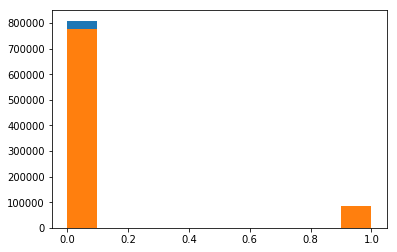

In [7]:
kk = model.predict(x_val,batch_size=batch_size,verbose=2)
print(kk)

print(kk.shape,y_val.shape)
plt.hist(np.round(kk))
plt.hist(y_val)
print(x_val.head())


In [8]:
print("Saved model to disk")
json_string = model.to_json()
with open("saved_models/model3.json", "w") as json_file:
    json_file.write(json_string)
model.save_weights('saved_models/weights3.h5')

Saved model to disk


In [9]:
print("predicting_test_sample")
dff = pd.read_csv('input_data/test_sampling5.csv')
print(dff.head())
dff, yy = clear_data(dff,'train')
dff = dff.drop(columns=['Unnamed: 0'])
output = model.predict(dff,batch_size=batch_size,verbose=2)


predicting_test_sample
   Unnamed: 0     ip  app  device  os  channel           click_time  \
0   178450426  63051   26       1  19      266  2017-11-09 14:00:13   
1   160852079  49602   26       2  19      266  2017-11-09 08:36:15   
2   118079796  25648    2       1   6      477  2017-11-08 14:49:12   
3   162379166   2965    8       1  19      140  2017-11-09 09:08:20   
4    84248176  20578   18       1  10      134  2017-11-08 04:33:53   

  attributed_time  is_attributed  
0             NaN              0  
1             NaN              0  
2             NaN              0  
3             NaN              0  
4             NaN              0  


[ 0.04842096  0.04885194  0.01897623 ...,  0.0188527   0.01941984
  0.01983825]
(18490389,)


(array([ 18445120.,         0.,         0.,         0.,         0.,
                0.,         0.,         0.,         0.,     45269.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

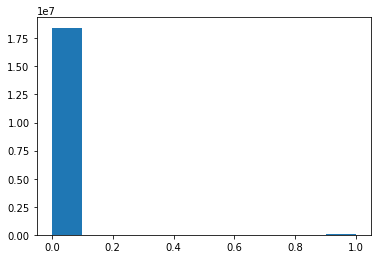

In [11]:
print(np.reshape(output,18490389))
print(yy.shape)
# dd = np.array([np.reshape(output,18490389),yy.values])

plt.hist(yy)



(array([  1.77557340e+07,   3.83489000e+05,   6.46730000e+04,
          3.79700000e+03,   2.23600000e+03,   2.62000000e+03,
          1.05144000e+05,   3.02980000e+04,   7.23200000e+03,
          1.35166000e+05]),
 array([ 0.0151433 ,  0.09926599,  0.18338868,  0.26751138,  0.35163407,
         0.43575676,  0.51987945,  0.60400214,  0.68812483,  0.77224752,
         0.85637021]),
 <a list of 10 Patch objects>)

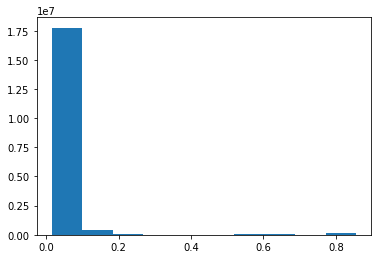

In [10]:
plt.hist(output)

In [12]:
print("predicting")
df_sub = pd.DataFrame()
ttest = pd.read_csv('input_data/kaggle_test.csv')
print("finish read test data")

ttest, idd = clear_data(ttest,'test')
df_sub['click_id'] = idd.astype('int32')
df_sub['is_attributed'] = model.predict(ttest,batch_size=batch_size,verbose=2)



predicting
finish read test data


check result
           click_id  is_attributed
count  1.879047e+07   1.879047e+07
mean   9.395234e+06   5.289930e-02
std    5.424341e+06   1.280222e-01
min    0.000000e+00   1.771144e-02
25%    4.697617e+06   1.885060e-02
50%    9.395234e+06   1.930582e-02
75%    1.409285e+07   2.038818e-02
max    1.879047e+07   8.563643e-01


(array([  1.78985720e+07,   2.19862000e+05,   1.00022000e+05,
          2.64500000e+03,   1.35000000e+03,   2.99800000e+03,
          7.45600000e+03,   1.05830000e+05,   1.61897000e+05,
          2.89837000e+05]),
 array([ 0.01771144,  0.10157673,  0.18544202,  0.2693073 ,  0.35317259,
         0.43703788,  0.52090316,  0.60476845,  0.68863374,  0.77249902,
         0.85636431]),
 <a list of 10 Patch objects>)

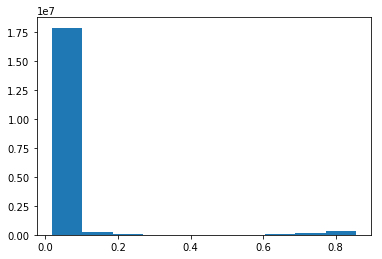

In [13]:
print("check result")
print(df_sub.describe())
plt.hist(df_sub['is_attributed'])

In [14]:
print("save the result")
df_sub.to_csv('sub_result/result_code3_sample5.csv',index=False)




save the result


(array([ 18224792.,         0.,         0.,         0.,         0.,
                0.,         0.,         0.,         0.,    565677.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

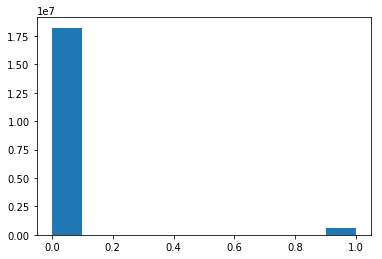

In [15]:
plt.hist(np.round(df_sub['is_attributed']))